<a href="https://colab.research.google.com/github/r-yv/coding-exercise/blob/main/part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Customer-level dataset sample:
  Customer ID  total_spending  purchase_frequency  avg_order_value  \
1     CUST001             150                   1            150.0   
2     CUST002            1000                   1           1000.0   
3     CUST003              30                   1             30.0   
4     CUST004             500                   1            500.0   
5     CUST005             100                   1            100.0   

   avg_quantity  category_diversity  age  
1           3.0                   1   34  
2           2.0                   1   26  
3           1.0                   1   50  
4           1.0                   1   37  
5           2.0                   1   30   



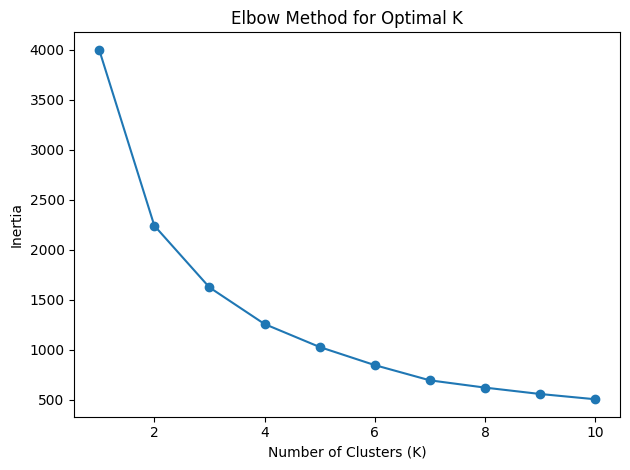

Elbow method results (inertia by K):
  K=1: inertia=4,000.00
  K=2: inertia=2,241.14
  K=3: inertia=1,623.59
  K=4: inertia=1,257.13
  K=5: inertia=1,027.25
  K=6: inertia=846.21
  K=7: inertia=693.92
  K=8: inertia=621.22
  K=9: inertia=557.26
  K=10: inertia=504.71

Selected K = 3
Justification: K is chosen near the 'elbow' where inertia stops dropping rapidly (largest curvature in the elbow plot).
Saved elbow plot to: elbow_plot.png

Cluster Characteristics (means):
         total_spending  purchase_frequency  avg_order_value  avg_quantity  \
cluster                                                                      
1                171.94                 1.0           171.94          1.43   
2               1297.73                 1.0          1297.73          3.20   
3                126.45                 1.0           126.45          3.55   

         category_diversity    age  
cluster                             
1                       1.0  41.90  
2                       

In [5]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


def resolve_dataset_path(filename: str) -> Path:
    """
    Finds the dataset by filename in Google Colab / notebooks:
    1) current working directory
    2) /mnt/data (common upload location in some environments)
    """
    p1 = Path.cwd() / filename
    if p1.exists():
        return p1

    p2 = Path("/mnt/data") / filename
    if p2.exists():
        return p2

    raise FileNotFoundError(
        f"Could not find '{filename}'. Upload it to the Colab session (Files pane) "
        f"or place it in the current working directory: {Path.cwd()}"
    )


def choose_elbow_k(inertias: list[float], k_values: list[int]) -> int:
    """
    Simple elbow heuristic:
    - Compute discrete 2nd derivative of inertia
    - Pick K where curvature magnitude is largest
    """
    if len(inertias) < 3:
        return k_values[-1]

    inertia_arr = np.array(inertias, dtype=float)
    first_diff = np.diff(inertia_arr)
    second_diff = np.diff(first_diff)

    elbow_idx = int(np.argmax(np.abs(second_diff)))
    elbow_k = k_values[elbow_idx + 2]
    return elbow_k


def main() -> tuple[pd.DataFrame, list[int], list[float], int]:

    filename = "retail_sales_dataset.csv"
    data_path = resolve_dataset_path(filename)
    df = pd.read_csv(data_path)


    customer_df = (
        df.groupby("Customer ID")
        .agg(
            total_spending=("Total Amount", "sum"),
            purchase_frequency=("Transaction ID", "count"),
            avg_order_value=("Total Amount", "mean"),
            avg_quantity=("Quantity", "mean"),
            category_diversity=("Product Category", "nunique"),
            age=("Age", "first"),
        )
        .reset_index()
    )
    customer_df.index = customer_df.index + 1
    print("Customer-level dataset sample:")
    print(customer_df.head(), "\n")


    features = [
        "total_spending",
        "purchase_frequency",
        "avg_order_value",
        "avg_quantity",
        "category_diversity",
        "age",
    ]

    X = customer_df[features].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)


    max_k = min(10, len(customer_df))
    k_values = list(range(1, max_k + 1))
    inertias: list[float] = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertias.append(float(kmeans.inertia_))

    plt.figure()
    plt.plot(k_values, inertias, marker="o")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Inertia")
    plt.title("Elbow Method for Optimal K")
    plt.tight_layout()
    plt.savefig("elbow_plot.png")
    plt.show()

    optimal_k = choose_elbow_k(inertias, k_values)

    print("Elbow method results (inertia by K):")
    for k, inertia in zip(k_values, inertias):
        print(f"  K={k}: inertia={inertia:,.2f}")
    print(f"\nSelected K = {optimal_k}")
    print(
        "Justification: K is chosen near the 'elbow' where inertia stops dropping rapidly "
        "(largest curvature in the elbow plot)."
    )
    print("Saved elbow plot to: elbow_plot.png\n")


    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    # SHIFT CLUSTER LABELS TO START AT 1 (instead of 0)
    customer_df["cluster"] = final_kmeans.fit_predict(X_scaled) + 1


    cluster_summary = customer_df.groupby("cluster")[features].mean().round(2)
    print("Cluster Characteristics (means):")
    print(cluster_summary, "\n")


    spending_median = customer_df["total_spending"].median()
    freq_median = customer_df["purchase_frequency"].median()

    print("Suggested Marketing Strategies:")
    for c in sorted(customer_df["cluster"].unique()):
        avg_spend = cluster_summary.loc[c, "total_spending"]
        avg_freq = cluster_summary.loc[c, "purchase_frequency"]
        avg_div = cluster_summary.loc[c, "category_diversity"]

        print(f"\nCluster {c}:")
        print(f"  - Avg total spending: {avg_spend:,.2f}")
        print(f"  - Avg purchase frequency: {avg_freq:,.2f}")
        print(f"  - Avg category diversity: {avg_div:,.2f}")

        if avg_spend >= spending_median and avg_freq >= freq_median:
            print("  Strategy: VIP/high-value customers → exclusive promos, early access, loyalty rewards.")
        elif avg_spend >= spending_median and avg_freq < freq_median:
            print("  Strategy: Big spenders but infrequent → personalized reminders, limited-time bundles, concierge support.")
        elif avg_spend < spending_median and avg_freq >= freq_median:
            print("  Strategy: Frequent buyers with smaller baskets → volume discounts, subscriptions, cross-sell add-ons.")
        else:
            print("  Strategy: Low-engagement customers → reactivation offers, welcome-back coupons, targeted product ads.")

        if avg_div >= customer_df["category_diversity"].median():
            print("  Extra: Diverse shoppers → recommend new categories and curated discovery campaigns.")
        else:
            print("  Extra: Focused shoppers → deepen category-specific promos and replenishment reminders.")


    out_path = Path("customer_segments.csv")
    customer_df.to_csv(out_path, index=False)
    print(f"\nSaved segmented customers to: {out_path.resolve()}")

    return customer_df, k_values, inertias, optimal_k


customer_df, k_values, inertias, optimal_k = main()